#  Model PEPS
The notebook below shows the variational circuit. We implement a tensor neural network using PEPS architecture.

<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Training](#3)
4. [Experiment 1 - 2 classes](#4)

Parameters:
* corpping - `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`
* image size to resize - `(64, 64)`
* PCA components - `256`
* Split data to train and validation - `train_ratio=0.8`
* cost functino - cross entropy 



| Experiment | Class | Training set         | Validation set       | Test set             | Cost function      | Epoch | Batch | Learning rate | Training time | Val_accuracy | Test_accuracy |
|------------|-----| ------------------|----------------------|----------------------|--------------------|-------|-------|----------------|---------------|--------------|---------------|
| 1     | 2     | [126 153] | [24 17]  | [50 30] | Cross-Entropy Loss | 70    | 64    | 0.05           | 0.5 h         | 56.81%       | 47.16%        |
| 2     | 2   | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 100   | 128   | 0.01           | 1 h           | 46.18%       | 42.5%          |
| 3     | 2    | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 215   | 32    | 0.01           | 1.5 h         | 48.18%       | 42.66%        |
| -     | 6    | [331 331 315 310 320 317] | - | [70 70 86 91 81 84] | Cross-Entropy Loss | 50   | -    | 0.1           | 2 h         | 55,9%          | 47.51%           |
| -     | 6    | [78 78 88 81 78 81] | - | [23 23 13 20 23 20] | Cross-Entropy Loss | 50   | -    | 0.1           |  -       | 55,9%          |  63.11%           |



<a id="1"></a> <br>
### Data Preparation


Initialize the ImageLoader to load and preprocess data.
Below, we load up to 100 images per label, applies cropping with specified parameters to focus on relevant image regions, and resizes each image to 64x64 pixels for consistency.

Cropping parameters: `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`.
Image size to resize: `(64, 64)`

In [1]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(['./Data_Sources/al5083/train'], ['./Data_Sources/al5083/train/train.json'], (64, 64))
all_data = loader.load_images(image_limit=200,vertical_start_split=0.3, vertical_end_split=1.0,
                              horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 1200, Current label: 5, Total per label: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}

Total images loaded : 1200


Create a balanced dataset for binary classification, where Class 1 consists of five different types of defective images.

In [2]:
from Modules.Utils import reduce_dataset_to_2_classes
binary_all_data = reduce_dataset_to_2_classes(all_data, class_0_count=200, other_classes_count=40)

Shuffles the dataset, flattens the image data arrays, scales the flattened features, and separates them into features and labels. Applies PCA to reduce the dimensionality of the given dataset to components = `256`

In [3]:
from  Modules.Utils import prepare_data
from Modules.Utils import apply_pca

X_set,Y_set = prepare_data(binary_all_data)
X_reduced = apply_pca(X_set, n_components=256)

Split train data to train set and validation set. `train_ratio=0.8`

In [4]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X = X_reduced, Y = Y_set, train_ratio=0.7, val_ratio=0.1,test_ratio=0.2)

Y_train: Values: [0 1] Counts: [126 153]
Y_val: Values: [0 1] Counts: [24 17]
Y_test: Values: [0 1] Counts: [50 30]


<a id="2"></a> <br>
### Model
While developing the model, we used:
* ["Supervised Learning with Projected Entangled Pair States" discusses the application of projected entangled pair states (PEPS)"](https://arxiv.org/abs/2009.09932) in constructing supervised learning models, particularly for image data
* [A practical introduction to tensor networks: Matrix product states and projected entangled pair states](https://www.sciencedirect.com/science/article/pii/S0003491614001596)

tensor([[0.45058398, 0.54941602]], requires_grad=True)

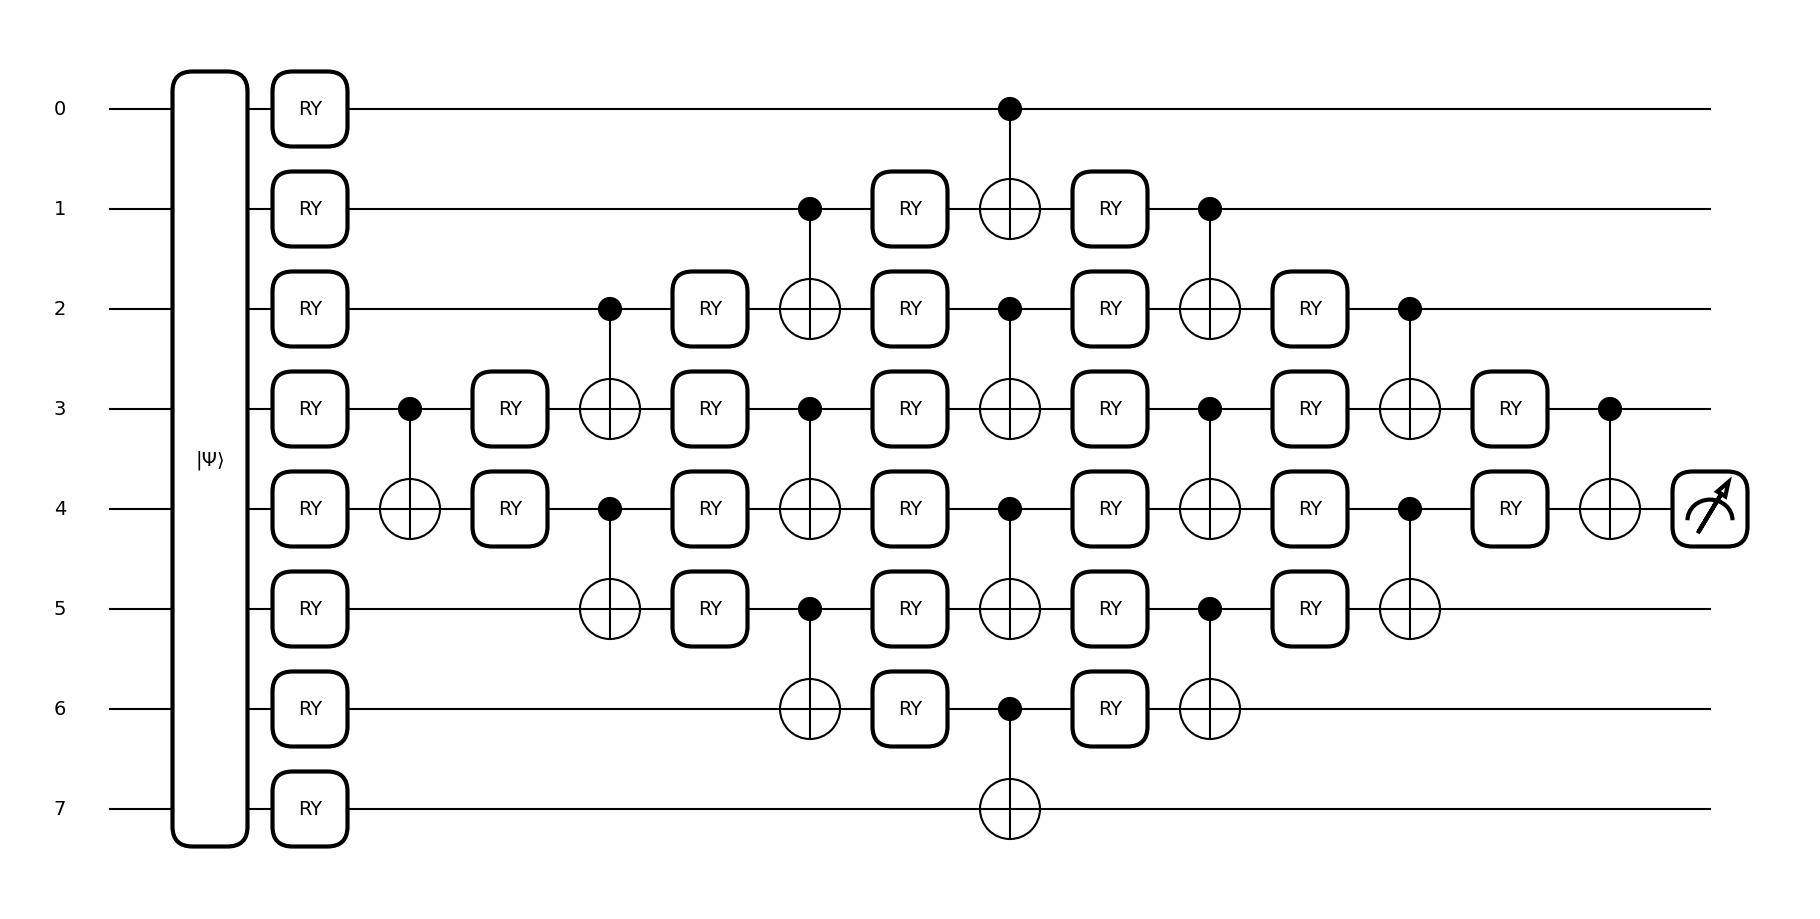

In [5]:
import pennylane as qml
from pennylane import numpy as np
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def circuit_peps(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    return qml.probs(wires = [4])

weights = np.random.random(size=[32, 1])
qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)
circuit_peps(X_train[0], weights)

<a id="3"></a> <br>
### Training
In this section, we perform the training process of the above model. Below, we see the cross entropy cost function. We use the following hyperparameters for training:
* `qml.AdamOptimizer(stepsize=0.1)`
* `batch_size = 64`
* `num_epoch = 150`

In [6]:
# training the circuit parameters
from pennylane import numpy as np
params = np.random.random(size=[32, 1], requires_grad=True)
optimizer = qml.AdamOptimizer(stepsize=0.1)
batch_size = 64
num_epoch = 150

In [9]:
from Modules.training import costfunc_cross_entropy
from Modules.metrices import accuracy
import time

start_time = time.time()
all_params,train_accuracies ,val_accuracies, costs = [], [], [], []
for epoch in range(num_epoch):

    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]

    params, cost = optimizer.step_and_cost(costfunc_cross_entropy, params, X=X_batch, Y=Y_batch, circuit = circuit_peps, num_classes = 2)

    current_cost = costfunc_cross_entropy(params, X=X_batch, Y=Y_batch, circuit = circuit_peps, num_classes = 2)

    acc_train = accuracy(params,X_batch,Y_batch,circuit_peps)
    acc_val = accuracy(params,X_val,Y_val,circuit_peps)

    print(f"Epoch: {epoch+1} | Cost: {current_cost:0.7f} | "f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}")

    train_accuracies.append(acc_train)
    val_accuracies.append(acc_val)
    all_params.append(params)
    costs.append(current_cost)
print(params)
print("--- %hr --- %", (time.time() - start_time)/3600)

Epoch: 1 | Cost: 0.6140385 | Acc train: 70.3125000 | Acc validation: 53.6585366
Epoch: 2 | Cost: 0.6330598 | Acc train: 67.1875000 | Acc validation: 60.9756098
Epoch: 3 | Cost: 0.6371295 | Acc train: 68.7500000 | Acc validation: 58.5365854
Epoch: 4 | Cost: 0.6472565 | Acc train: 54.6875000 | Acc validation: 46.3414634
Epoch: 5 | Cost: 0.6403529 | Acc train: 65.6250000 | Acc validation: 51.2195122
Epoch: 6 | Cost: 0.6327918 | Acc train: 62.5000000 | Acc validation: 53.6585366
Epoch: 7 | Cost: 0.5843060 | Acc train: 71.8750000 | Acc validation: 65.8536585
Epoch: 8 | Cost: 0.6068952 | Acc train: 67.1875000 | Acc validation: 70.7317073
Epoch: 9 | Cost: 0.6300945 | Acc train: 68.7500000 | Acc validation: 70.7317073
Epoch: 10 | Cost: 0.6344481 | Acc train: 62.5000000 | Acc validation: 73.1707317
Epoch: 11 | Cost: 0.5859508 | Acc train: 73.4375000 | Acc validation: 68.2926829
Epoch: 12 | Cost: 0.6368501 | Acc train: 65.6250000 | Acc validation: 65.8536585
Epoch: 13 | Cost: 0.6388812 | Acc tra

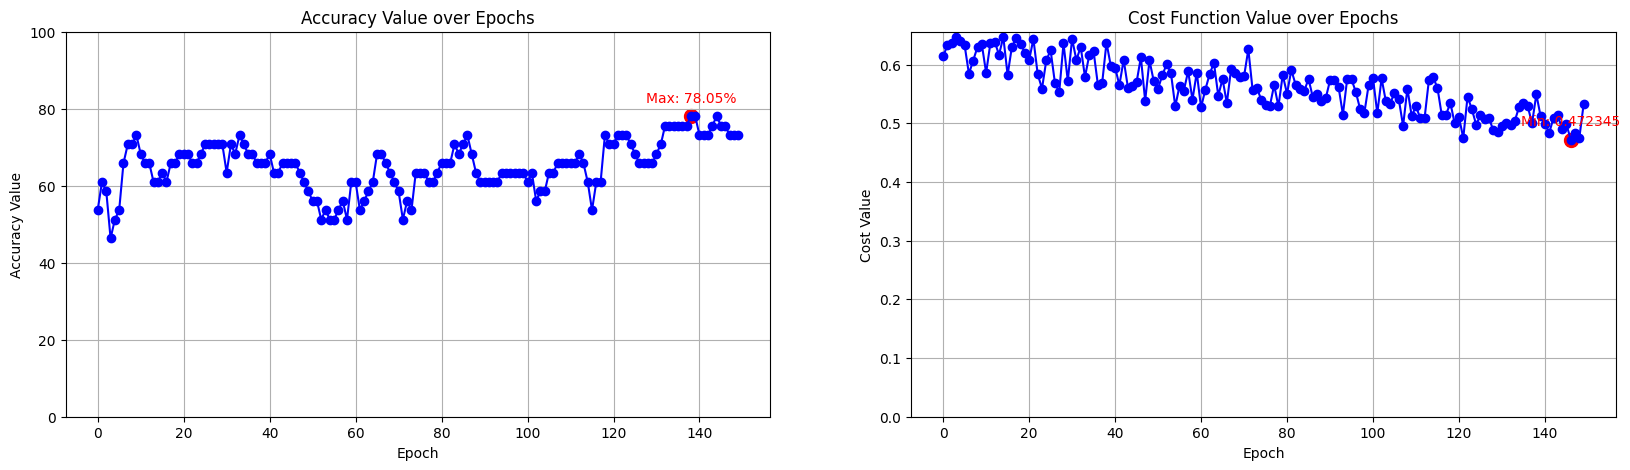

In [2]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(val_accuracies,costs)

In the cell below, we evaluate the model using different sets of parameters. We use the parameters corresponding to the minimum cost function value, the maximum validation set accuracy, and the final parameters returned at the end of the training process.
Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [27]:
# Find the parameters that give the minimum cost
params_min_costs = all_params[np.argmin(costs)]
test_accuracy_min_costs = accuracy(params_min_costs, X_test, Y_test, circuit_peps)

# Find the parameters that give the maximum validation accuracy
params_max_val_accuracy = all_params[np.argmax(val_accuracies)]
test_accuracy_max = accuracy(params_max_val_accuracy, X_test, Y_test, circuit_peps)

# Calculate test accuracy for the final parameters after the last epoch
test_accuracy_final = accuracy(params, X_test, Y_test, circuit_peps)

print(f"Test Accuracy with params giving minimum cost: {test_accuracy_min_costs:.4f}")
print(f"Test Accuracy with params giving maximum validation accuracy: {test_accuracy_max:.4f}")
print(f"Test Accuracy with final parameters: {test_accuracy_final:.4f}")

Test Accuracy with params giving minimum cost: 0.8250
Test Accuracy with params giving maximum validation accuracy: 0.7875
Test Accuracy with final parameters: 0.4375


We take params for minimum cost function value. This params is saved as '02_Peps_binary_Exp1.txt' in experiment output.

In [16]:
from Modules.metrices import show_all_metrics
show_all_metrics(params_min_costs, X_test, Y_test, circuit_peps)

Accuracy: 0.6750 | Precision: 0.5556 | Recall: 0.6667 | F1 Score: 0.6061 | AUC-ROC: 0.6733 | Balanced Accuracy: 0.6733
              precision    recall  f1-score   support

     class 0       0.77      0.68      0.72        50
     class 1       0.56      0.67      0.61        30

    accuracy                           0.68        80
   macro avg       0.66      0.67      0.66        80
weighted avg       0.69      0.68      0.68        80

